In [17]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchdiffeq import odeint
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import seaborn as sns

In [18]:
sns.set()

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

In [3]:
class ResBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut

In [21]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc_compl(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.conv3 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm4 = norm(dim)
        self.conv4 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm5 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        out = self.relu(out)
        out = self.conv3(t, out)
        out = self.norm4(out)
        out = self.relu(out)
        out = self.conv4(t, out)
        out = self.norm5(out)
        return out

    
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [5]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [6]:
def get_mnist_loaders(data_aug=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [7]:
def learning_rate_with_decay(lr, batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    #logger.info(filepath)
    #with open(filepath, "r") as f:
    #    logger.info(f.read())

    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())

    return logger

In [9]:
tol = 1e-3
downsampling_method = 'res'
epochs=100
data_aug = True
lr = 1e-3
batch_size = 128
test_bs = 1024 #??

save_dir = './exp1' 

In [22]:
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

In [23]:
makedirs(save_dir)
logger = get_logger(logpath=os.path.join(save_dir, 'logs'), filepath=os.path.abspath('.'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

is_odenet = True

if downsampling_method == 'conv':
    downsampling_layers = [
        nn.Conv2d(1, 64, 3, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
    ]
elif downsampling_method == 'res':
    downsampling_layers = [
        nn.Conv2d(1, 64, 3, 1),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
    ]

#feature_layers = [ODEBlock(ODEfunc(64)) for _ in range(2)] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
#feature_layers = [ODEBlock(ODEfunc_compl(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]

fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

#logger.info
print(model)
#logger.info
print('Number of parameters: {}'.format(count_parameters(model)))

criterion = nn.CrossEntropyLoss().to(device)

train_loader, test_loader, train_eval_loader = get_mnist_loaders(data_aug, batch_size, test_bs)

data_gen = inf_generator(train_loader)
batches_per_epoch = len(train_loader)

lr_fn = learning_rate_with_decay( lr, batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch,
                                 boundary_epochs=[20, 40, 60],decay_rates=[1, 0.1, 0.01, 0.001])

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

best_acc = 0
field_names = list(map(lambda l:l.strip().split()[0],
                       "Epoch {:4d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} |"
                       "Train_Acc {:.4f} | Test_Acc {:.4f} | Total_Time {:.3f}".split('|')))
logs_1 = []

batch_time_meter = RunningAverageMeter()
f_nfe_meter = RunningAverageMeter()
b_nfe_meter = RunningAverageMeter()
end = time.time()
start = time.time()

for itr in range(epochs * batches_per_epoch):

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_fn(itr)

    optimizer.zero_grad()
    x, y = data_gen.__next__()
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    loss = criterion(logits, y)

    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0

    loss.backward()
    optimizer.step()

    if is_odenet:
        nfe_backward = feature_layers[0].nfe
        feature_layers[0].nfe = 0

    batch_time_meter.update(time.time() - end)
    if is_odenet:
        f_nfe_meter.update(nfe_forward)
        b_nfe_meter.update(nfe_backward)
    end = time.time()

    if itr % batches_per_epoch == 0:
        finish = time.time()
        with torch.no_grad():
            train_acc = accuracy(model, train_eval_loader)
            val_acc = accuracy(model, test_loader)
            if val_acc > best_acc:
                torch.save({'state_dict': model.state_dict()}, os.path.join(save_dir, 'model.pth'))
                best_acc = val_acc
            #logger.info
            print(
                "Epoch {:4d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                "Train_Acc {:.4f} | Test_Acc {:.4f} | Total_Time {:.3f}".format(
                    itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                    b_nfe_meter.avg, train_acc, val_acc, finish - start
                )
            )
            logs_1.append(dict(zip(field_names, [ itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                    b_nfe_meter.avg, train_acc, val_acc, finish - start])))
            start = time.time()

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (3): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=Tr

KeyboardInterrupt: 

In [24]:
logs_1

[{'Epoch': 0,
  'Time': 1.1663413047790527,
  'NFE-F': 1.1663413047790527,
  'NFE-B': 26,
  'Train_Acc': 0,
  'Test_Acc': 0.09775,
  'Total_Time': 0.0897},
 {'Epoch': 1,
  'Time': 1.1237423419952393,
  'NFE-F': 0.3518146520107296,
  'NFE-B': 26.113337826255613,
  'Train_Acc': 0.0,
  'Test_Acc': 0.9629833333333333,
  'Total_Time': 0.8998},
 {'Epoch': 2,
  'Time': 1.1690211296081543,
  'NFE-F': 0.35646780732408767,
  'NFE-B': 26.160499026848903,
  'Train_Acc': 0.0,
  'Test_Acc': 0.972,
  'Total_Time': 0.9077},
 {'Epoch': 3,
  'Time': 1.1619246006011963,
  'NFE-F': 0.3541097996338256,
  'NFE-B': 26.160926447915926,
  'Train_Acc': 0.0,
  'Test_Acc': 0.9729833333333333,
  'Total_Time': 0.9052},
 {'Epoch': 4,
  'Time': 1.202782154083252,
  'NFE-F': 0.34110854730643125,
  'NFE-B': 24.95415771513177,
  'Train_Acc': 0.0,
  'Test_Acc': 0.9805,
  'Total_Time': 0.9138},
 {'Epoch': 5,
  'Time': 1.12302827835083,
  'NFE-F': 0.3201531668305314,
  'NFE-B': 22.928928317852208,
  'Train_Acc': 0.0,
  'Te

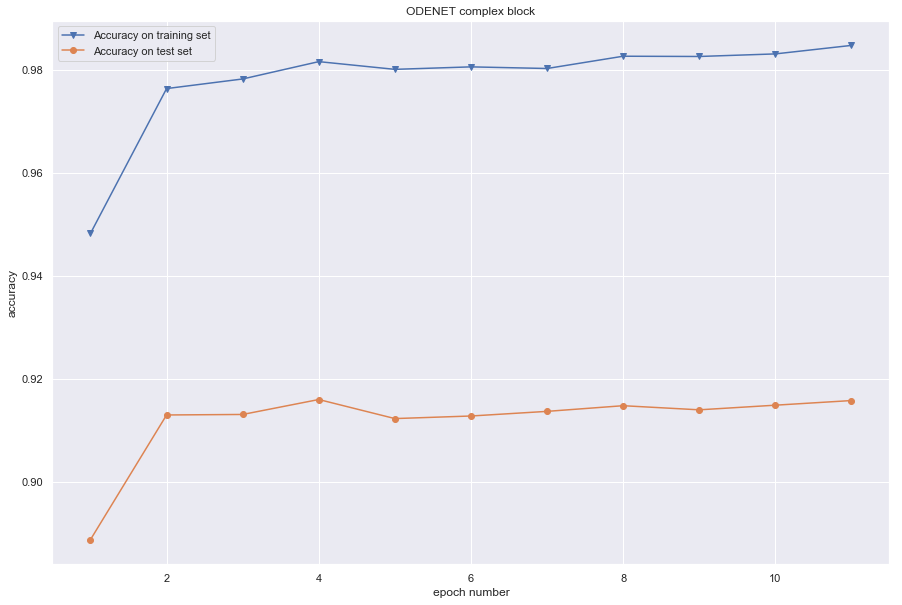

In [20]:
plt.figure(figsize=(15, 10))
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.title('ODENET complex block')
plt.plot(np.arange(len(train_ac_3[1:])) + 1, train_ac_3[1:], label='Accuracy on training set', marker='v')
plt.plot(np.arange(len(test_ac_3[1:])) + 1, test_ac_3[1:], label='Accuracy on test set', marker='o')
plt.legend()
plt.savefig('odenet_3.pdf', bbox_inches='tight')

In [15]:
test_ac_3 = [elem['Total_Time'] for elem in logs_3]
train_ac_3 = [elem['Test_Acc'] for elem in logs_3]


In [25]:
test_ac_1 = [elem['Total_Time'] for elem in logs_1]
train_ac_1 = [elem['Test_Acc'] for elem in logs_1]


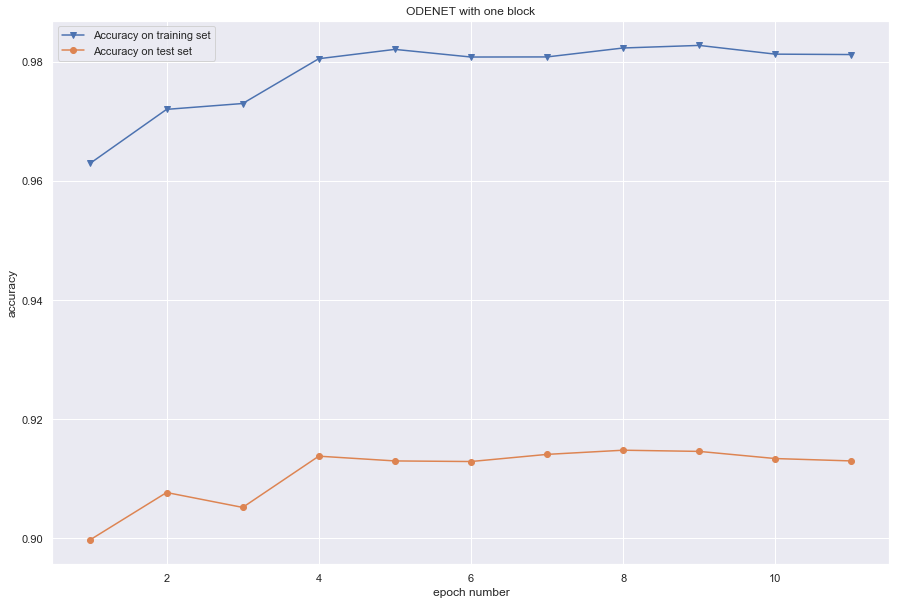

In [26]:
plt.figure(figsize=(15, 10))
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.title('ODENET with one block')
plt.plot(np.arange(len(train_ac_1[1:])) + 1, train_ac_1[1:], label='Accuracy on training set', marker='v')
plt.plot(np.arange(len(test_ac_1[1:])) + 1, test_ac_1[1:], label='Accuracy on test set', marker='o')
plt.legend()
plt.savefig('odenet_1.pdf', bbox_inches='tight')